In [1]:
#!/usr/bin/python

from IPython.display import Image
import sys
import pickle
from matplotlib import pyplot as plt
import os
import pprint
import pandas as pd
import seaborn as sns
import time
import numpy as np

%matplotlib inline


sys.path.append("../tools/")


In [2]:
os.getcwd()

'F:\\Users\\Me\\Google Drive\\Udacity\\Data_Science_Nano_Degree\\Intro_to_machine_learning\\ud120-projects\\final_project'

In his presentation "Machine Learning Gremlins" Ben Hammer suggests the following process model for tackling machine learning problems:

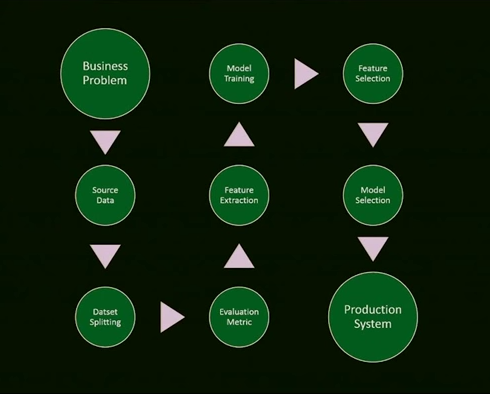

In [3]:
Image(filename='Machine-Learning-Process.png') 

Common issues to look at for include:

* Data leakage
    - introducing information about your classification target which has nothing to to with the actual target
        - grass in background of dog photos
        - previous prostate surgery for identifying prostate cancer
    - to avoid:  it is important to understand what the most important variables are in your model and how they are being used
* Overfitting
    - to avoid:  pay close attention to training error vs validation error or k-fold cross validation
    - make sure to split the data into training and testing sets

#Task 0:  Explore the data
Before getting into the machine learning exercies, we first need to load and explore the Enron dataset.

In [4]:
#navigate up one folder with "../" prefix
#we need to deserialize, extract the data structure from byte code, using the pickle module
enron_data = pickle.load(open("../final_project/final_project_dataset.pkl", "r"))

Now let's look at the type of data structure and the size of it

In [5]:
print ("Data type: {}".format(type(enron_data)))
data_entries = len(enron_data)
print("length of Enron dictionary is {}".format(data_entries))

Data type: <type 'dict'>
length of Enron dictionary is 146


So we have a dictionary of lengh 146. Let's see what's in it:

In [6]:
#for data in enron_data:
#    print (data, enron_data[data])

Given that the dictionary keys for enron_data are people let's print out the list of attributes for each person:

In [7]:
pprint.pprint(enron_data["METTS MARK"])
features = len(enron_data["METTS MARK"])
print("\n Each person in the Enron dataset has {} features".format(features))

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

 Each person in the Enron dataset has 21 features


Now let's identify hom many poi's are in the dataset?

In [8]:
def poi_count():
    poi_count = 0
    for i in enron_data:
        #print enron_data[i]["poi"]
        if enron_data[i]["poi"] == True:
            poi_count += 1
    return "total poi count = %s" %poi_count

poi_count()  

'total poi count = 18'

With 18 poi's, we have 128 non-poi's (146-18).  Now let's look at the number of NaN's in the dataset for each feature:

In [9]:
NaNs = {}
for person in enron_data:
    for feature in enron_data[person]:
        if enron_data[person][feature] == "NaN":
            if feature in NaNs:
                NaNs[feature] += 1.
            else:
                NaNs[feature] = 1.

pprint.pprint(NaNs)



{'bonus': 64.0,
 'deferral_payments': 107.0,
 'deferred_income': 97.0,
 'director_fees': 129.0,
 'email_address': 35.0,
 'exercised_stock_options': 44.0,
 'expenses': 51.0,
 'from_messages': 60.0,
 'from_poi_to_this_person': 60.0,
 'from_this_person_to_poi': 60.0,
 'loan_advances': 142.0,
 'long_term_incentive': 80.0,
 'other': 53.0,
 'restricted_stock': 36.0,
 'restricted_stock_deferred': 128.0,
 'salary': 51.0,
 'shared_receipt_with_poi': 60.0,
 'to_messages': 60.0,
 'total_payments': 21.0,
 'total_stock_value': 20.0}


Several features have a lot of NaNs.  Features with the highest number of NaNs are unlikely to be useful as features in our model.

In [10]:
#here we find the percentage of NaNs for each feature to aid in feature selection
for feature in NaNs:
    NaNs[feature] = NaNs[feature]/data_entries

pprint.pprint(NaNs)
        

{'bonus': 0.4383561643835616,
 'deferral_payments': 0.7328767123287672,
 'deferred_income': 0.6643835616438356,
 'director_fees': 0.8835616438356164,
 'email_address': 0.23972602739726026,
 'exercised_stock_options': 0.3013698630136986,
 'expenses': 0.3493150684931507,
 'from_messages': 0.410958904109589,
 'from_poi_to_this_person': 0.410958904109589,
 'from_this_person_to_poi': 0.410958904109589,
 'loan_advances': 0.9726027397260274,
 'long_term_incentive': 0.547945205479452,
 'other': 0.363013698630137,
 'restricted_stock': 0.2465753424657534,
 'restricted_stock_deferred': 0.8767123287671232,
 'salary': 0.3493150684931507,
 'shared_receipt_with_poi': 0.410958904109589,
 'to_messages': 0.410958904109589,
 'total_payments': 0.14383561643835616,
 'total_stock_value': 0.136986301369863}


#Task 1a:  Select Features

Here is a list of all the financial features available in the dataset:

In [11]:
financial_features = ["poi",  'bonus', 'deferral_payments', 'deferred_income', 
                      'director_fees', 'exercised_stock_options', 'expenses', 
                      'loan_advances', 'long_term_incentive', 'restricted_stock', 
                      'restricted_stock_deferred', 'salary', 'total_payments', 
                      'total_stock_value']

#Task 3a:  Create new features
Here we create a feature called non-salary referring to total_payments - salary

In [12]:
def non_salary():
    for person in enron_data:
        non_salary = 0
        for feature in financial_features:
            if feature == "total_payments" or feature == "salary" or feature == "poi" or enron_data[person][feature] == "NaN":
                pass
            else:
                non_salary += enron_data[person][feature]
        enron_data[person]["non_salary"] = non_salary
    return enron_data
                #non_salary += enron_data[person][feature]

enron_data = non_salary()
#add non_salary to list of financial features
financial_features.append("non_salary")

In [13]:
print financial_features

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'non_salary']


#Taks 1b:  Select Features

Here we remove features that have more than 40% of entries that are NaN

In [14]:
def NaN_cutoff(cut_off):
    #let's remove from the list of financial_features any features where more than 40% of the data_entries are NaN
    for feature in NaNs:
        #print feature
        if feature in financial_features:
            if NaNs[feature] > cut_off:
                financial_features.remove(feature)

    return financial_features   

financial_features = NaN_cutoff(0.5)
financial_features

['poi',
 'bonus',
 'exercised_stock_options',
 'expenses',
 'restricted_stock',
 'salary',
 'total_payments',
 'total_stock_value',
 'non_salary']

####Addititional feature selection undertaken below in Section 4

#Task 2: Remove Outliers


##Load data

In [15]:
print enron_data

{'METTS MARK': {'to_messages': 807, 'deferral_payments': 'NaN', 'expenses': 94299, 'poi': False, 'deferred_income': 'NaN', 'email_address': 'mark.metts@enron.com', 'long_term_incentive': 'NaN', 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 702, 'non_salary': 1864423, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'director_fees': 'NaN', 'bonus': 600000, 'total_stock_value': 585062, 'from_poi_to_this_person': 38, 'from_this_person_to_poi': 1, 'restricted_stock': 585062, 'salary': 365788, 'total_payments': 1061827, 'exercised_stock_options': 'NaN'}, 'BAXTER JOHN C': {'to_messages': 'NaN', 'deferral_payments': 1295738, 'expenses': 11200, 'poi': False, 'deferred_income': -1386055, 'email_address': 'NaN', 'long_term_incentive': 1586055, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 'NaN', 'non_salary': 23953454, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'director_fees': 'NaN', 'bonus': 1200000, 'total_stock_value': 10623

In [16]:
#let's put the financial features into a pandas dataframe and visualize their relationship
df = pd.DataFrame.from_dict(enron_data, orient = "index")#navigate up one folder with "../" prefix 
df_financial = df[financial_features]

In [17]:
## Explore outliers in the financial features

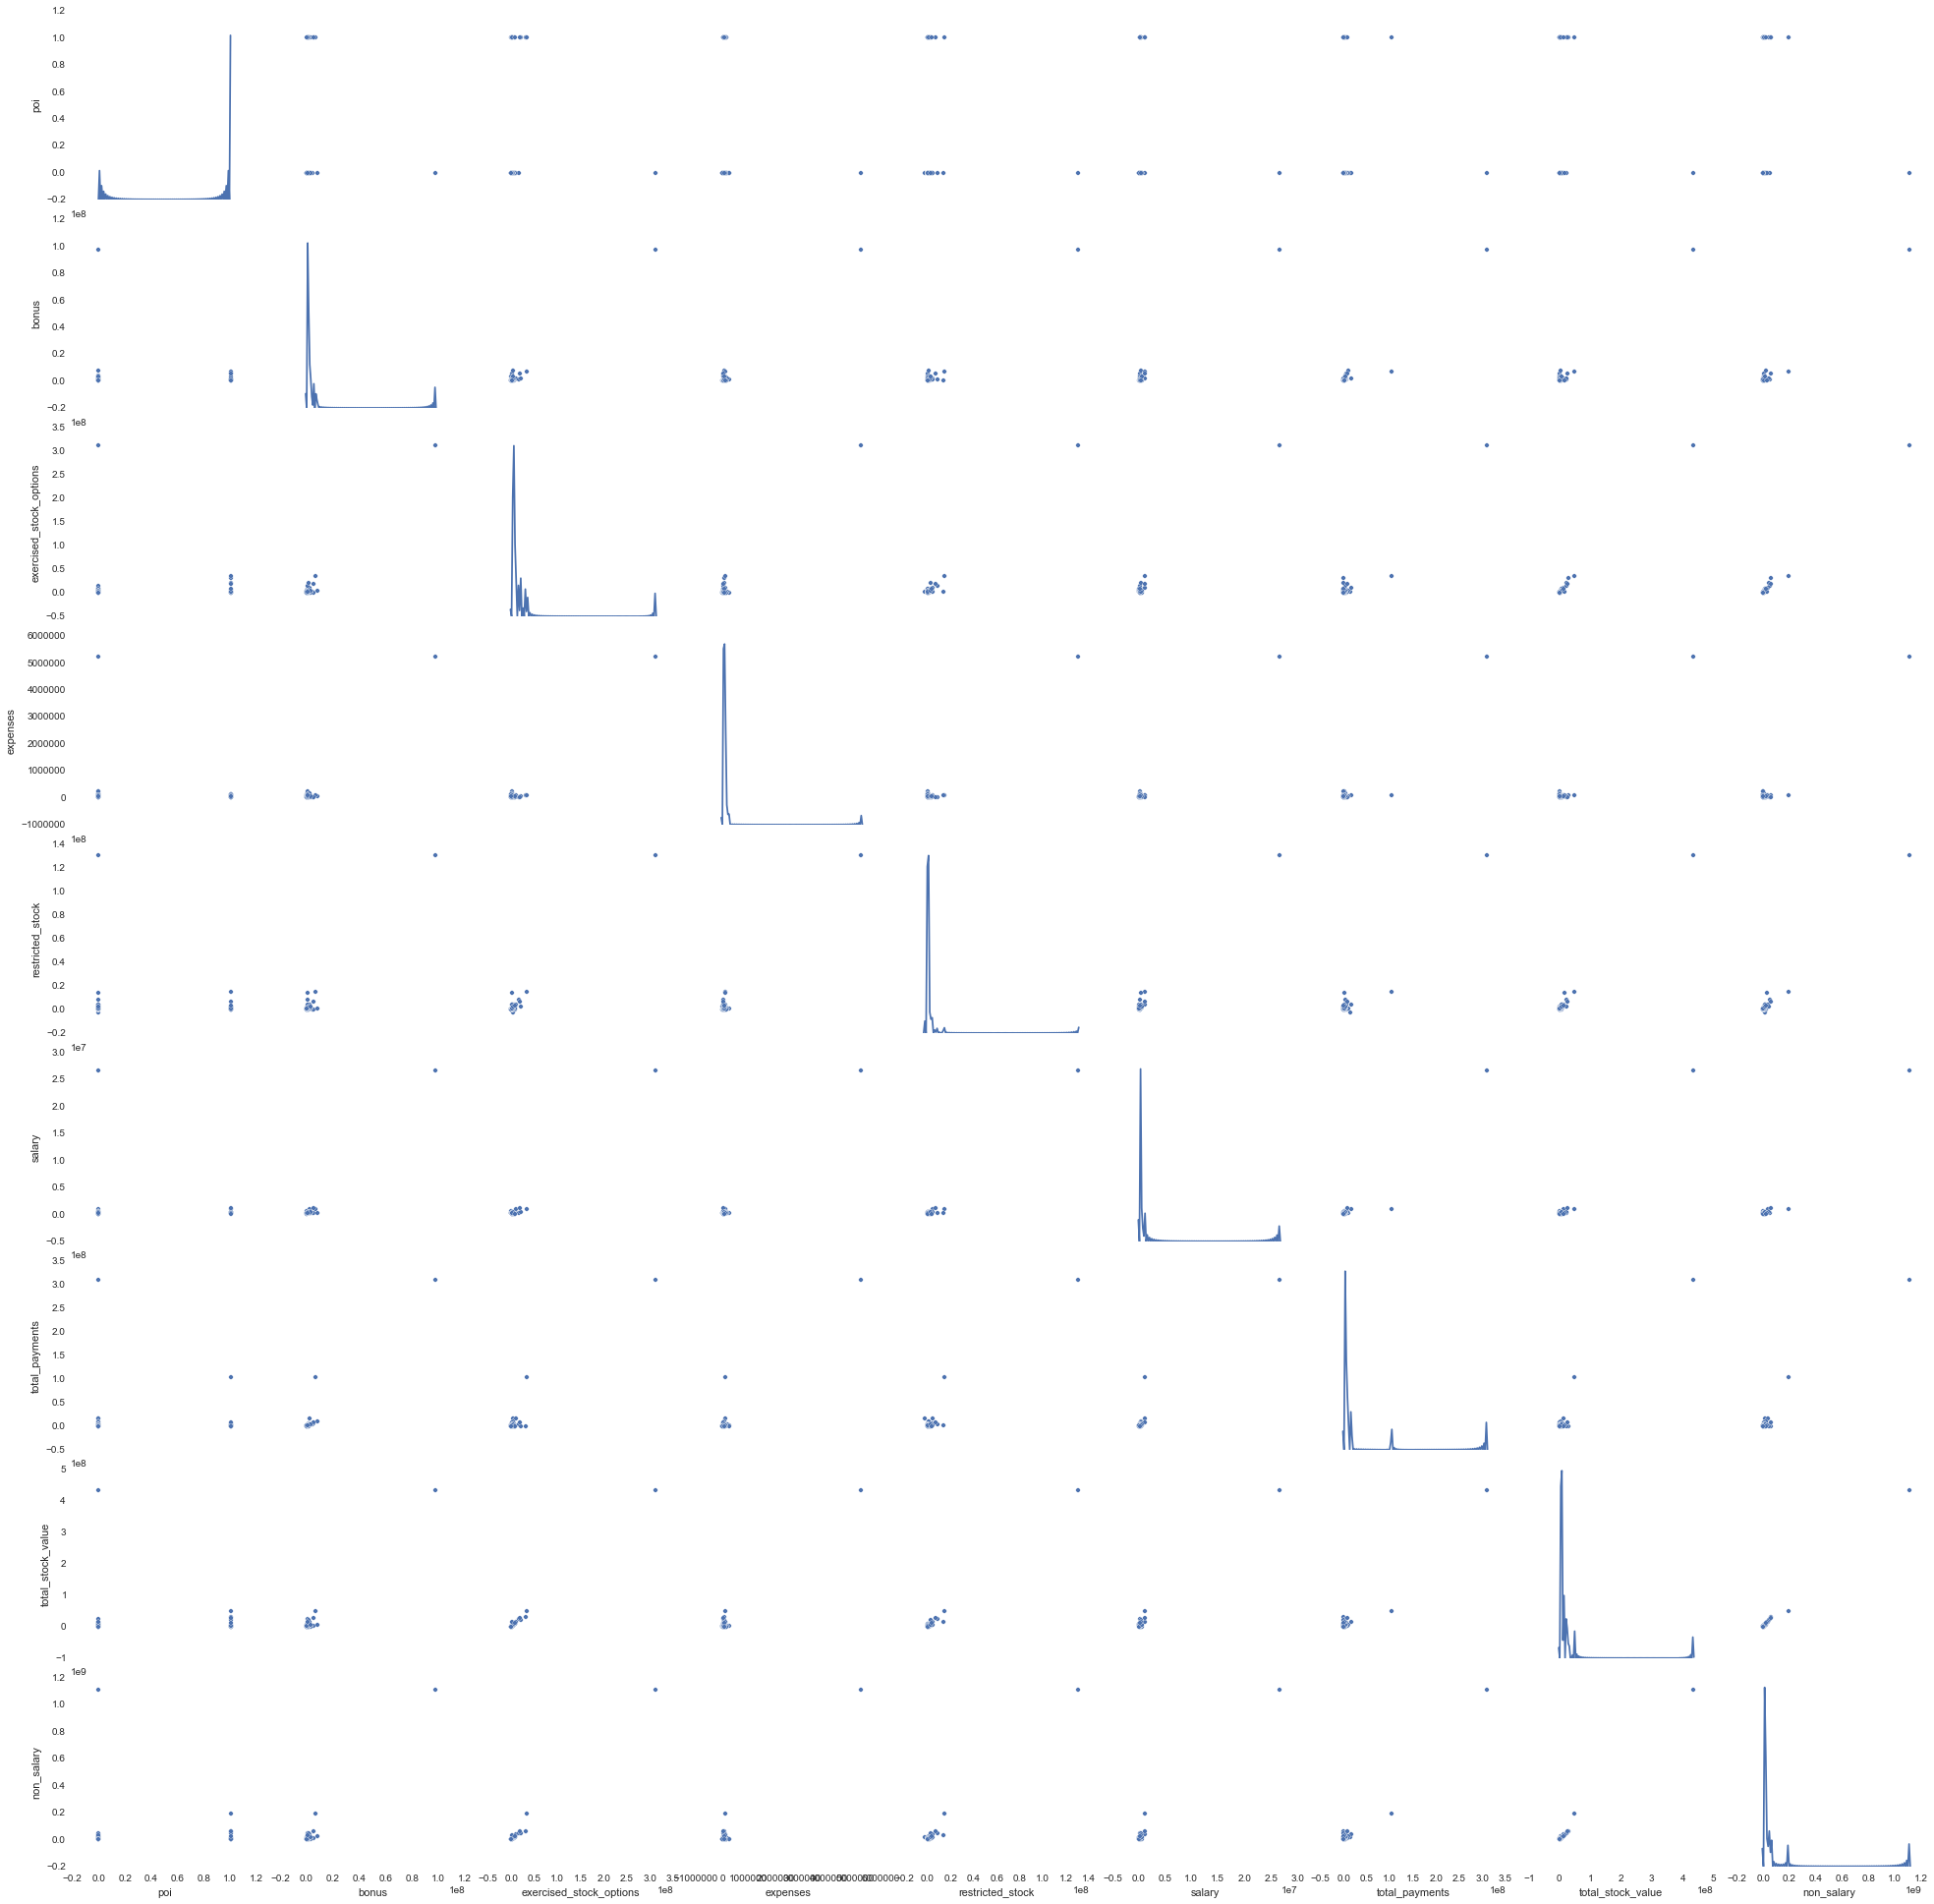

In [18]:

sns.pairplot(df_financial, diag_kind="kde")

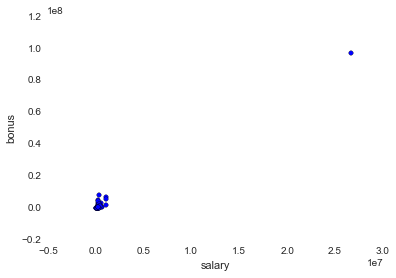

In [19]:
from feature_format import featureFormat, targetFeatureSplit
import matplotlib.pyplot as plt

features = ["salary", "bonus"]


def scatter(x, y):


    #Now plot the data again
    data = featureFormat(enron_data, features)

    for point in data:
        salary = point[0]
        bonus = point[1]
        plt.scatter( salary, bonus )
        plt.xlabel(x)
        plt.ylabel(y)
        
scatter(features[0], features[1])

It looks like we have a number of outliers as all of the data is clusstered in very small areas.  Let's take one financial data pair to investigate the outliers a little further.

Looks like we have a big outlier.  Let's see what the max salary is for the outlier

In [20]:
def max_feature(feature):
    feature_list = []
    for person in enron_data:
        if enron_data[person][feature] != "NaN":
            feature_list.append(enron_data[person][feature])
    return max(feature_list)
    
max_feature("salary")

26704229

Who does this outlier belong to?

In [21]:
def max_person(feature):
    for person in enron_data:
        if enron_data[person][feature] == max_feature(feature):
            return person
            #break
            
max_person("salary")

'TOTAL'

Let's remove this summary statistic and replot the data

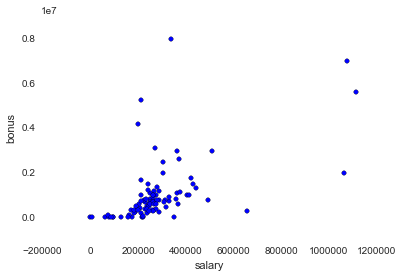

In [22]:
def remove(feature):
    for person in enron_data:
        if enron_data[person][feature] == max_feature(feature):
            enron_data.pop(person, 0 )
            break

remove("salary")
            
scatter(features[0], features[1])

There are stil a few outliers in the data

In [23]:
def salary_outliers():
    outliers = []
    for person in enron_data:
        if enron_data[person]["salary"] > 1000000 or enron_data[person]["bonus"]>5000000:
            if enron_data[person]["salary"] != "NaN" and enron_data[person]["bonus"] != "NaN":
                #print person, data_dict[person]["salary"], data_dict[person]["bonus"]
                outliers.append(person)
    print outliers
    
salary_outliers()

['LAVORATO JOHN J', 'LAY KENNETH L', 'BELDEN TIMOTHY N', 'SKILLING JEFFREY K', 'FREVERT MARK A']


Since the remaining outliers are all people, we'll keep them in the dataset.  But let's just check to see who all the biggest outliers are across all of the financial features:

In [24]:
for feature in financial_features:
    print"Person: ", max_person(feature),"Feature:", feature

Person:  HANNON KEVIN P Feature: poi
Person:  LAVORATO JOHN J Feature: bonus
Person:  LAY KENNETH L Feature: exercised_stock_options
Person:  MCCLELLAN GEORGE Feature: expenses
Person:  LAY KENNETH L Feature: restricted_stock
Person:  SKILLING JEFFREY K Feature: salary
Person:  LAY KENNETH L Feature: total_payments
Person:  LAY KENNETH L Feature: total_stock_value
Person:  LAY KENNETH L Feature: non_salary


Now let's replot the financial features with a scatter plot matrix

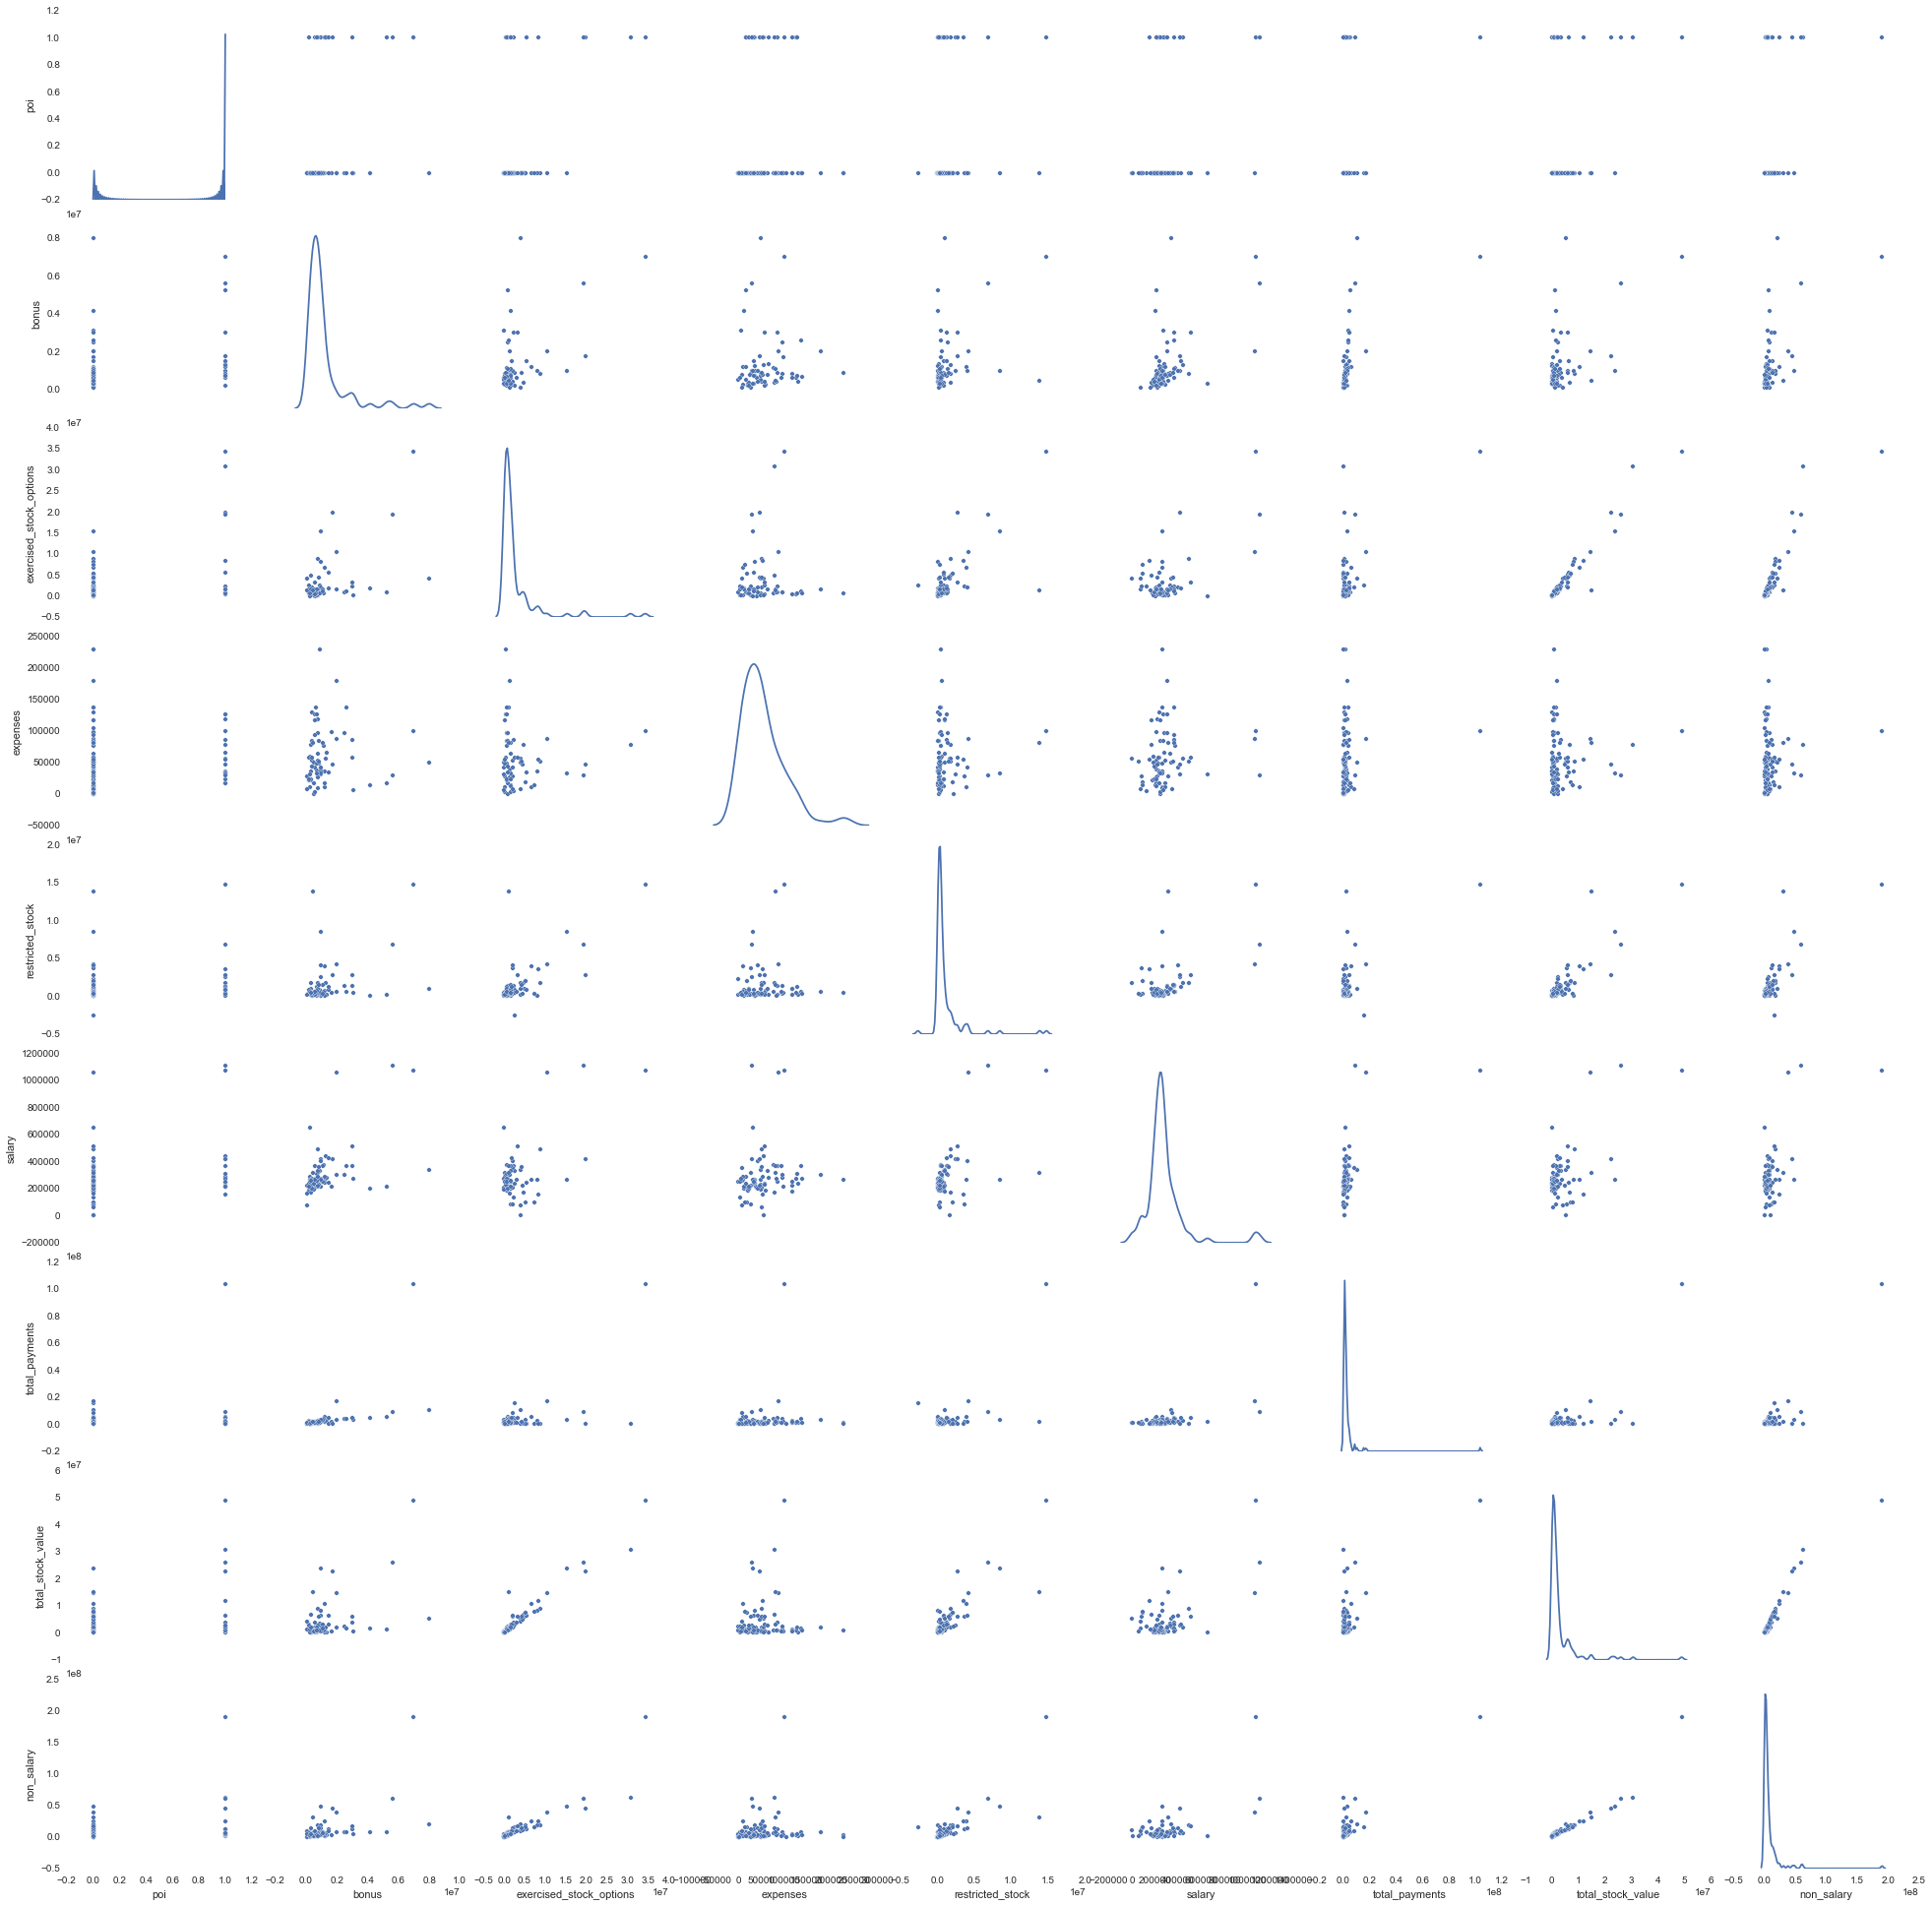

In [25]:
df = pd.DataFrame.from_dict(enron_data, orient = "index")
df_financial = df[financial_features]
sns.pairplot(df_financial, diag_kind="kde")

#Preprocessing Data

In [26]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from tester import test_classifier, dump_classifier_and_data

from sklearn.grid_search import GridSearchCV
from pprint import pprint



###Step 1:  Re-formate data into a set of numpy arrays and split it into training and testing sets.
When selecting features, make sure to always train your model on a subset of the data to ensure the model isn't overfit.

In [27]:
#guided by lesson 6 regression
#first we need to format the financial features.  
#featureFormat takes a dictionary and a list of features, and returns a numpy array for each feature
#The first feature in the feature list is the poi classification.
#All NaNs are converted to 0, and data points are removed if all of the features are zero.  
data = featureFormat( enron_data, financial_features, remove_NaN =True, remove_all_zeroes = True)
#targetFeatureSplit splits the data into the target (i.e. poi classification) and features
targets, features = targetFeatureSplit(data)



###Feature selection with girdsearchCV

In [40]:
#guided by:
#http://scikit-learn.org/stable/modules/cross_validation.html
"""
Just as it is important to test a predictor on data held-out from training, 
preprocessing (such as standardization, feature selection, etc.) and similar 
data transformations similarly should be learnt from a training set and 
applied to held-out data for prediction
"""

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, random_state=0)

scaler = MinMaxScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
clf = SelectKBest()#.fit(X_train_transformed, y_train)
params = [{"clf__score_func": [chi2, f_regression],
          "clf__k": ["all"]}]

scores = ['accuracy', 'precision', 'recall']

for score in scores:
    clf = GridSearchCV(clf, params, cv=5,
                       scoring=score)#'%s_weighted' % score)
    clf.fit(X_train_transformed, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    #y_true, y_pred = y_test, clf.predict(X_test_transformed)
    #print(classification_report(y_true, y_pred))
    print()
    print("score")
    print()
    print(clf.score(X_test_transformed, y_test))

AttributeError: 'SelectKBest' object has no attribute 'predict'

###Step 2:  Split dataset into training and testing sets

In [29]:

#stratefiedshufflesplit code from Udacity:
#Please note cross validation is an iterative process where train/test are generated 
#until results converges, that is, are not dependent of the dataset characteristics. 
#Please note the iterative process is repeated 1000 times!
cv = StratifiedShuffleSplit(targets, 1000, random_state = 42)
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    targets_train   = []
    targets_test    = []

    features_train = [features[ii] for ii in train_idx]
    targets_train = [targets[ii] for ii in train_idx]
    features_test = [features[jj] for jj in test_idx]
    targets_test = [targets[jj] for jj in test_idx]



In [30]:
###Step 3:  Scaling
####Scale Features
#Now let's normalize the financial features before applying principle component analysis for feature reduction


scaler = MinMaxScaler()
#fit and transform training data and transform testing data
#http://scikit-learn.org/stable/modules/preprocessing.html
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

#Task 2b:  Feature selection using SelectKBest

In [32]:
print financial_features

['poi', 'bonus', 'exercised_stock_options', 'expenses', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value', 'non_salary']


In [68]:
#http://scikit-learn.org/stable/auto_examples/feature_stacker.html#example-feature-stacker-py
#here we want to select the best features that can tell us who the poi's are (what methods does selectKbest use?)

def features_select(method, k):
    
    select = SelectKBest(method, k=k)
    #Note that only transform is applied to test data. Targets do not require transformation 
    features_train_scaled_kbest = select.fit_transform(features_train_scaled, targets_train)
    features_test_scaled_kbest = select.transform(features_test_scaled)
    
    #construct a list of kbest features
    financial_features_kbest = ["poi"]
    for i, feature in enumerate(select.get_support()):
        if feature == True:
            #print i, feature, financial_features[i+1]
            financial_features_kbest.append(financial_features[i+1]) 
    
    #print financial_features
    #print financial_features_kbest
    #print select.get_support()
    #print select.scores_
    
    return financial_features_kbest, features_train_scaled_kbest, features_test_scaled_kbest


for i in np.arange(1, len(financial_features)):
    print i, features_select(chi2,i)[0]

1 ['poi', 'exercised_stock_options']
2 ['poi', 'exercised_stock_options', 'total_stock_value']
3 ['poi', 'exercised_stock_options', 'total_stock_value', 'non_salary']
4 ['poi', 'exercised_stock_options', 'total_payments', 'total_stock_value', 'non_salary']
5 ['poi', 'exercised_stock_options', 'expenses', 'total_payments', 'total_stock_value', 'non_salary']
6 ['poi', 'bonus', 'exercised_stock_options', 'expenses', 'total_payments', 'total_stock_value', 'non_salary']
7 ['poi', 'bonus', 'exercised_stock_options', 'expenses', 'salary', 'total_payments', 'total_stock_value', 'non_salary']
8 ['poi', 'bonus', 'exercised_stock_options', 'expenses', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value', 'non_salary']


# Task 4:  Try a variety of classifiers

###Step 4: Dimensionality Reduction with scaled data (all financial features with less than 50% NaNs included here)
Here we take a little detour to explore dimensionality reduction
####Feature Selection & Dimensionality Reduction
Feature selection and dimensionality reduction are both processes of reducing the number of variables we consider in our analysis but they go about reducing the number of variables in different ways.  While features selection involves selecting the most important features (and excluding others from the analysis), dimensionality reduction involves combining features to make new features.  Principle component analysis is a great example of diminsionality reduction.  

[Jason Brownlee](http://machinelearningmastery.com/an-introduction-to-feature-selection/) identifies three general types of feature selection:

* Filter Methods,
* Wrapper Methods, and
* Embedded Methods

Embeded methods learn the best features while the model is being created.  Wrapper methods compare different combinations of features.  Filter methods apply statistical techniques to score each feature.  Below, recursive feature elimination (wrapper method) and two embedded methods - Lasso regression and linear support vector machine classification - are used to select financial features. 


####Principle Component Analysis

By setting n_components=3 below, we are reducing the n-dimensional space (where n=len(features)) to 3 principle component dimensions.  These principle components represent the 1st, 2nd, and 3rd dimensions of max variance and the principle components are orthogonal to each other.  If this is confusing, it should because it is impossible to visualize reducing n-dimensions to 3 dimensions.  

In [34]:
#guided by lesson 12 mini project
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(features_train)
print pca.explained_variance_ratio_ 
print sum(pca.explained_variance_ratio_)

[ 0.94082585  0.05121398  0.00607707]
0.998116902733


####Here we show how to access and plot the first two principle components for the first two features

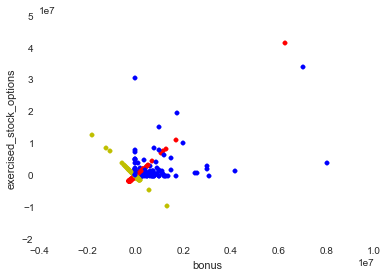

In [35]:
#each pca component contains a vector transformation to get from 
#the pca back to the original features
pc_1st = pca.components_[0]
pc_2nd = pca.components_[1]
pc_3rd = pca.components_[2]


#transform the original 8 features into the principle features
feature_train_pca = pca.transform(features_train)

#use zip here to combine each list into a list of tuples
#iterate through the list of transformed features.
#ii contains the aggregated principle components, and jj contains the 
#original data points for each feature.  
for ii, jj in zip(feature_train_pca, features_train):
    #plot the 
    plt.scatter(pc_1st[0]*ii[0], pc_1st[1]*ii[0], color="r")
    plt.scatter(pc_2nd[0]*ii[1], pc_2nd[1]*ii[1], color="y")
    plt.scatter(jj[0], jj[1], color="b")

plt.xlabel(financial_features[1+0])
plt.ylabel(financial_features[1+1])
plt.show()
    
    


####And for comparison, we plot the top two pinciple components of the 3rd and 4th features

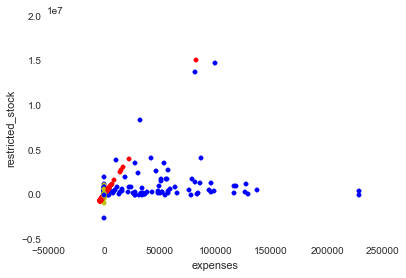

In [36]:
#use zip here to combine each list into a list of tuples
#iterate through the list of transformed original features
for ii, jj in zip(feature_train_pca, features_train):
    #plot the 
    plt.scatter(pc_1st[2]*ii[0], pc_1st[3]*ii[0], color="r")
    plt.scatter(pc_2nd[2]*ii[1], pc_2nd[3]*ii[1], color="y")
    plt.scatter(jj[2], jj[3], color="b")

plt.xlabel(financial_features[1+2])
plt.ylabel(financial_features[1+3])
plt.show()

####Dimensionality Reduction without normalization
Now let's see what happens when we use PCA without applying feature scaling.  

In [37]:
pca.fit(features_train)

pca.explained_variance_ratio_ #this contains the eigenvalues

array([ 0.94082585,  0.05121398,  0.00607707])

In [38]:
print ("So the first 3 principle components explain %s, %s and %s of the variance, respectively" \
       %(pca.explained_variance_ratio_[0], \
       pca.explained_variance_ratio_[1], \
       pca.explained_variance_ratio_[2]))

So the first 3 principle components explain 0.940825847404, 0.0512139806328 and 0.00607707469574 of the variance, respectively


In [39]:
#extract each of the three principle components each of which contain the linear 
#transformation needed to get from the back to the principle components for each 
#of the features
pc_1st = pca.components_[0]
pc_2nd = pca.components_[1]
pc_3rd = pca.components_[2]

print pc_1st, "\n", pc_2nd, "\n", pc_3rd

[  2.89884389e-02   1.92909055e-01   3.83480784e-04   7.02356558e-02
   4.46023082e-03   3.82678923e-01   2.63028647e-01   8.61025814e-01] 
[ -5.57350501e-02   3.99415045e-01   1.19638174e-05   3.68206059e-02
  -5.16230142e-03  -7.94978231e-01   4.32336657e-01   1.30665399e-01] 
[ 0.01922576 -0.596325    0.00270696  0.76249005  0.01823247 -0.15748884
  0.17249881  0.08796293]


What happens when we remove the "linear transformation"?

## Task 4 & 5:  Explore and Tune the Classifier

###Use LinearSVC() to classify poi's without normalization or feature selection


####Without feature scaling:
<span style="color: red">This method is innappropriate because the enron_data is not scaled</span>

####With feature scaling:
<span style="color: red">This method is innappropriate because the enron_data is not scaled</span>

<b>1) Run SelectKBest through the pipeline</b>

In [100]:
t= time.time()

pipeline = Pipeline([('scaler', scaler), 
                     ('feature_selection', SelectKBest(chi2, k=4)),
                     ('classifier', LinearSVC())])
test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=4, score_func=<function chi2 at 0x000000002ED89278>)), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.87180	Precision: 0.59459	Recall: 0.12100	F1: 0.20108	F2: 0.14393
	Total predictions: 15000	True positives:  242	False positives:  165	False negatives: 1758	True negatives: 12835

1.41499996185


<b>2) "Hard code" features selected above using SelectKBest</b>

This was recommended because StratifiedShuffleSplit() is used for validation when we run the evaluation metrics using test_classifier() which produces different training and testing sets and can therefore lead to different SelectKBest features for each training and testing set.

In [101]:


t= time.time()

pipeline = Pipeline([('scaler', scaler), 
                     ('classifier', LinearSVC())])
test_classifier(pipeline, enron_data, features_select(chi2, 4)[0])

print time.time()-t



Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.87953	Precision: 0.75196	Recall: 0.14400	F1: 0.24171	F2: 0.17178
	Total predictions: 15000	True positives:  288	False positives:   95	False negatives: 1712	True negatives: 12905

0.733000040054


When the features are "hard coded" we see considerably higher precision and recall

##Using gridsearch for parameter tuning of LinearSVC
<span style="color: red">@Tairi suggests that "you do not need to create or implement k-fold cross-validation procedure if you are using Grid Search1. It automatically does it for you."  However, note that [this sklearn example](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html) passes training data to the grid search .fit function.</span>

In [160]:
#double underscore notation:  http://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv
#http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html#example-model-selection-grid-search-digits-py
parameters = [{'classifier__C': [1, 10, 100, 1000]
                    }]

pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ("classifier", LinearSVC())
    ])

scores = ['precision',"recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    #gridsearch with same cv as test_classifier
    clf = GridSearchCV(pipeline, parameters, cv=cv, 
                       scoring= score)#'%s_weighted' %
    clf.fit(features, targets)
    pred = clf.predict(features)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print "Accuracy: ", accuracy_score(targets, pred)
    print 'Precision:', precision_score(targets, pred)
    print 'Recall:', recall_score(targets, pred)

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'svm__C': 100}
Accuracy:  0.895104895105
Precision: 0.8
Recall: 0.222222222222
# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'svm__C': 1000}
Accuracy:  0.895104895105
Precision: 1.0
Recall: 0.166666666667


In [158]:
C = [1, 10, 100, 1000]

for i in C:
    pipeline = Pipeline([
            ('scaler', scaler),
            ("classifier", LinearSVC(C=i))
        ])

    test_classifier(pipeline, enron_data, financial_features)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86220	Precision: 0.40970	Recall: 0.07600	F1: 0.12822	F2: 0.09079
	Total predictions: 15000	True positives:  152	False positives:  219	False negatives: 1848	True negatives: 12781

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86847	Precision: 0.52432	Recall: 0.14550	F1: 0.22779	F2: 0.17008
	Total predictions: 15000	True positives:  291	False positives:  264	False negatives: 1709	True negatives: 12736

Pipeline(steps=[(

###The same GridSearchCV as above with feature selection added to the pipeline

In [167]:
#double underscore notation:  http://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv
#http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html#example-model-selection-grid-search-digits-py
parameters = [{'features__k': [1, 2, 3, 4, 5, 6, 7, 8],
                     'features__score_func': [chi2, f_classif],
                     'classifier__C': [1, 10, 100, 1000], 
                    }]
pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('features', SelectKBest()),
        ("classifier", LinearSVC())
    ])


for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipeline, parameters, cv=cv, 
                       scoring=score)#'%s_weighted' % 
    clf.fit(features, targets)
    pred = clf.predict(features)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print "Accuracy: ", accuracy_score(targets, pred)
    print 'SVM Precision:', precision_score(targets, pred)
    print 'SVM recall:', recall_score(targets, pred)


# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'features__score_func': <function chi2 at 0x000000002ED89278>, 'classifier__C': 10, 'features__k': 2}
Accuracy:  0.895104895105
SVM Precision: 0.8
SVM recall: 0.222222222222
# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'features__score_func': <function chi2 at 0x000000002ED89278>, 'classifier__C': 1000, 'features__k': 7}
Accuracy:  0.881118881119
SVM Precision: 0.666666666667
SVM recall: 0.111111111111


###Use hard-coded kbest features and re-run using tuned parameters

In [168]:
pipeline = Pipeline([
        ('scaler', scaler),
        ("svm", LinearSVC(C=10))
    ])

test_classifier(pipeline, enron_data, features_select(chi2, 2)[0])

pipeline = Pipeline([
        ('scaler', scaler),
        ("svm", LinearSVC(C=1000))
    ])
test_classifier(pipeline, enron_data, features_select(chi2, 7)[0])

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86623	Precision: 0.74576	Recall: 0.19800	F1: 0.31292	F2: 0.23209
	Total predictions: 13000	True positives:  396	False positives:  135	False negatives: 1604	True negatives: 10865

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.80633	Precision: 0.23241	Recall: 0.19650	F1: 0.21295	F2: 0.20277
	Total predictions: 15000	True positives:  393	False positives: 1298	False negatives: 1607	True negatives: 11702



Again their is a discrepancy between the gridsearch results and the test_classifier results

###Explore scores for different kbest features selection

<b>PCA with support vector machine using original features (not selectKBest features)</b>

In [169]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('dim_reduction', pca), 
                     ('classifier', LinearSVC())])

test_classifier(pipeline, enron_data, financial_features)

print time.time()-t

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('dim_reduction', PCA(copy=True, n_components=3, whiten=False)), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.86807	Precision: 0.52618	Recall: 0.10550	F1: 0.17576	F2: 0.12558
	Total predictions: 15000	True positives:  211	False positives:  190	False negatives: 1789	True negatives: 12810

1.75500011444


##Adaboost
###Using gridsearch for parameter tuning of Adaboost


In [171]:
#attempt to integrate kbest features
parameters = {'features__k': [1, 2, 3, 4, 5, 6, 7, 8],
              'features__score_func': [chi2, f_classif],
              'abc__n_estimators': [10, 25, 50, 75, 100, 200]}

pipeline = Pipeline([
        ('scaler', scaler),
        ('features', SelectKBest()),
        ("abc", AdaBoostClassifier())
    ])

scores = ['precision',"recall"]


for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipeline, parameters, cv=cv, 
                       scoring=score)#'%s_weighted' % 
    clf.fit(features, targets)
    pred = clf.predict(features)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print "Accuracy: ", accuracy_score(targets, pred)
    print 'SVM Precision:', precision_score(targets, pred)
    print 'SVM recall:', recall_score(targets, pred)

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'features__score_func': <function chi2 at 0x000000002ED89278>, 'features__k': 7, 'abc__n_estimators': 200}
Accuracy:  1.0
SVM Precision: 1.0
SVM recall: 1.0
# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'features__score_func': <function chi2 at 0x000000002ED89278>, 'features__k': 3, 'abc__n_estimators': 200}
Accuracy:  1.0
SVM Precision: 1.0
SVM recall: 1.0


In [ ]:
pipeline = Pipeline([
        ('scaler', scaler),
        ("abc", AdaBoostClassifier(n_estimators=200))
    ])

test_classifier(pipeline, enron_data, features_select(i)[0])

###Explore scores for different kbest features selection

In [49]:
###Explore scores for different kbest features selection
pipeline = Pipeline([
        ('scaler', scaler),
        ("abc", AdaBoostClassifier(n_estimators=200))
    ])

for i in np.arange(1, len(financial_features)):
    print i, test_classifier(pipeline, enron_data, features_select(i))

1 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None))])
	Accuracy: 0.85518	Precision: 0.25597	Recall: 0.31100	F1: 0.28081	F2: 0.29818
	Total predictions: 11000	True positives:  311	False positives:  904	False negatives:  689	True negatives: 9096

None
2 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None))])
	Accuracy: 0.80738	Precision: 0.32950	Recall: 0.24350	F1: 0.28005	F2: 0.25691
	Total predictions: 13000	True positives:  487	False positives:  991	False negatives: 1513	True negatives: 10009

None
3 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_

In [47]:
###Explore scores for different kbest features selection
pipeline = Pipeline([
        ('scaler', scaler),
        ("abc", AdaBoostClassifier(n_estimators=50))
    ])

for i in np.arange(1, len(financial_features)):
    print i, test_classifier(pipeline, enron_data, features_select(i))

 1 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.87091	Precision: 0.29769	Recall: 0.30900	F1: 0.30324	F2: 0.30667
	Total predictions: 11000	True positives:  309	False positives:  729	False negatives:  691	True negatives: 9271

None
2 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.82654	Precision: 0.39889	Recall: 0.25150	F1: 0.30849	F2: 0.27157
	Total predictions: 13000	True positives:  503	False positives:  758	False negatives: 1497	True negatives: 10242

None
3 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_e

Adaboost(n_estimator=50), highest precision where recall>0.3 is for features_select(5)

In [46]:
###Explore scores for different kbest features selection
pipeline = Pipeline([
        ('scaler', scaler),
        ("abc", AdaBoostClassifier(n_estimators=25))
    ])

for i in np.arange(1, len(financial_features)):
    print i, test_classifier(pipeline, enron_data, features_select(i))

 1 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None))])
	Accuracy: 0.85518	Precision: 0.25597	Recall: 0.31100	F1: 0.28081	F2: 0.29818
	Total predictions: 11000	True positives:  311	False positives:  904	False negatives:  689	True negatives: 9096

None
2

KeyboardInterrupt: 

In [48]:
###Explore scores for different kbest features selection
pipeline = Pipeline([
        ('scaler', scaler),
        ("abc", AdaBoostClassifier(n_estimators=25))
    ])

for i in np.arange(1, len(financial_features)):
    print i, test_classifier(pipeline, enron_data, features_select(i))

1 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=25, random_state=None))])
	Accuracy: 0.89982	Precision: 0.42917	Recall: 0.30900	F1: 0.35930	F2: 0.32733
	Total predictions: 11000	True positives:  309	False positives:  411	False negatives:  691	True negatives: 9589

None
2 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=25, random_state=None))])
	Accuracy: 0.83300	Precision: 0.42699	Recall: 0.25000	F1: 0.31536	F2: 0.27260
	Total predictions: 13000	True positives:  500	False positives:  671	False negatives: 1500	True negatives: 10329

None
3 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_es

Adaboost(n_estimator=50), highest precision where recall>0.3 is for features_select(3)

<b>RandomForestClassifier</b>

In [108]:
#double underscore notation:  http://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv
parameters = {
    'clf__max_depth': (1,2,4,6,8,10), 
    'clf__n_estimators':(5, 10, 50, 100),
    'clf__min_samples_split': [1,2,3,4,5], 
    "clf__min_samples_leaf": [1,2,3,4,5],
    "clf__max_leaf_nodes": [2,3,4,5]
}

pipeline = Pipeline(steps=[
            ('normalization', scaler), 
            ('clf', RandomForestClassifier())
        ])

grid_search = GridSearchCV(pipeline, parameters, scoring='recall')
grid_search.fit(features_train, targets_train)
grid_search.best_estimator_

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=5,
            min_samples_leaf=3, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

<b>KNeighborsClassifier</b>

<b>Here, decreasing the number of features from 4 to 3 relative to the tuned classifer I have selected increases precision by more than 10% while decreasing recall by only about 1%.</b>

In [ ]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('classifier', KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

print type(test_classifier(pipeline, enron_data, features_select(3)))

print time.time()-t

In [ ]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('classifier', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

test_classifier(pipeline, enron_data, features_select(3))

print time.time()-t

In [ ]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('classifier', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

test_classifier(pipeline, enron_data, features_select(4))

print time.time()-t

<b>Compared to the final algorithm selected below, increasing n_neighbors from 3 to 5 increased precision by more than 10%, and reduced recall by about 1%.</b>

In [ ]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

test_classifier(pipeline, enron_data, features_select(3))#kbest features passed

print time.time()-t

In [ ]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('classifier', KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', 
                                                         leaf_size=150, p=1, metric='minkowski'))])

test_classifier(pipeline, enron_data, features_select(3))

print time.time()-t

####Select the tuned algorithm with good accuracy, precision and recall

In [ ]:
t= time.time()
pipeline = Pipeline([('normalization', scaler), 
                     ('classifier', KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', 
                                                         leaf_size=30, p=1, metric='minkowski'))])

test_classifier(pipeline, enron_data, features_select(4))

print time.time()-t


###Data dump

In [ ]:

### Dump your classifier, dataset, and features_list so 
### anyone can run/check your results.

dump_classifier_and_data(pipeline, enron_data, features_select(4))

###Additional methods to explore include:

* using k-fold cross-validation to improve model validation